# Iskanje in prenos posnetkov

## Viri satelitskih posnetkov

Količina razpoložljivih satelitskih posnetkov srednje in visoke ločljivosti se je v zadnjem desetletju močno povečala. Satelitski sistemi kot je [Sentinel-2](https://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2) (Copernicus, EU), [Landsat](https://landsat.usgs.gov/) (USGS) in [PlanetScope](https://www.planet.com/docs/spec-sheets/sat-imagery/) (Planet) omogočajo praktično dnevno spremljanje stanja površja.

Tehnološke spremembe pa spreminjajo tudi način dostopa do podatkov in obdelavo. Postopke je potrebno avtomatizirati ter jih prilagoditi izvajanju v oblaku. Od obdelave enega ali nekaj posnetkov smo prešli do obdelave goste časovne vrste in velikih (prostorskih) podatkov (big geospatial data) ter uporabe umetne inteligence pri interpretaciji.

## Načini dostopa

Do satelitskih posnetkov lahko dostopamo prek spletnih portalov, ki mogočajo iskanje, naročanje in prenos posnetkov. Večina jih omogoča tudi API dostop, ponudniki pogosto ponujajo knjižnice za različne prograsmke jezike, praviloma Python.

| Satelit                     | Spletni portal                            | API                                                                          |
|-----------------------------|-------------------------------------------|------------------------------------------------------------------------------|
| Landsat                     | https://earthexplorer.usgs.gov/           | https://earthexplorer.usgs.gov/inventory/documentation/json-api              |
| Planet, Landsat, Sentinel-2 | https://www.planet.com/explorer/          | https://www.planet.com/docs/                                                 |
| Sentinel-2                  | https://scihub.copernicus.eu/             | https://scihub.copernicus.eu/twiki/do/view/SciHubWebPortal/APIHubDescription |
| Landsat, Sentinel-2, MODIS  | https://apps.sentinel-hub.com/eo-browser/ | https://www.sentinel-hub.com/develop/documentation/api                       |
| Landsat 8, Sentine-2        | https://search.descarteslabs.com/         | https://docs.descarteslabs.com/                                              |                     |

Enostaven dostop do spetlnih servisov, iskanje, prenos in deloma statistično obdelavo obstaja veliko knjižnic za različne programsek jezike. Knjižnice se razlikujejo glede enostavnost in zmogljivosti. Nekaj zmogljvojših za Python:

* https://github.com/dgketchum/Landsat578
* https://github.com/yoannMoreau/landsat_theia
* https://pythonhosted.org/landsat-util/
* https://github.com/planetlabs/planet-client-python
* https://github.com/olivierhagolle/Sentinel-download
* https://github.com/sentinel-hub/sentinelhub-py

Zaradi enostavnosti dela in zmogljivosti bomo uporabili Sentinel Hub in knjižnico SentinelHub-Py.

## Potrebne knjižnice

Satelitski posnetki so običajne rastrske datoteke, torej (velike) matrike. Za njihovo branje, obdelavo in pretvorbo, potrebujemo več knjižnic.

In [1]:
# Potrebne knjižnice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentinelhub as shub

In [2]:
# Parametri beležnice
%reload_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Sentinel Hub račun

Za dostop do Sentinel Huba je potrebna registracija. Ko imamo uporabniško ime in geslo, moramo na konfikuratorju ustvariti sloje oziroma storitve do katerih želmo dostopati. Konfigurator je dostopen na naslovu:  
https://apps.sentinel-hub.com/configurator/#/

![](./slike/sh_configuration_utility.png)

Za dostop prek Pythona potrebujemo ID ustvarjene konfiguracije. ID ključ je vezan na osebo. Praviloma ga ne delimo in zato tudi ne zapisujemo beležnico. Lahko ga preberemo iz datoteke, v skrajnem primeru definiramo spremenljivko `INSTANCE_ID`, ki je niz znakov.

Dostop do posameznih slojev je mogoč prek njihovega ID.

![](./slike/sh_configuration_utility_layers.png)

In [3]:
# ID ključ mora biti definiran, preberemo ga iz datoteke
sentinelhub_id = 'sentinelhub.id'
f = open(sentinelhub_id,'r')
exec(f.readline())

In [4]:
if 'INSTANCE_ID' in locals():
    print("Sentinel Hub INSTANCE_ID obstaja")
    print(INSTANCE_ID)

Sentinel Hub INSTANCE_ID obstaja
f20f09f6-2bc3-46ed-8e96-438b69e367da


## Iskanje satelitskih posnetkov

Poiskali bomo sateliske posnetke območja med Kranjem in Škofjo Loko. Najprej definiramo območje. Sentinel Hub pozna različne koordinatne sisteme, mi bomo uporabili kar WGS84 in torej geografske koordinate. Potrebujemo geografsko širini in dolžino zgornjega levega in spodnjega desnega kota. Oboje bi lahko prebrali iz ustrezne datoteke, recimo GeoJSON ali SHP. Koordinate lahko odčitamo iz poljubne spletne karte ([Google Maps](https://www.google.si/maps/), [GeoJSON.io](http://geojson.io/)) ali namiznega GIS programa (QGIS, ArcMap). Ustvariti moramo omočje `sentinelhub.common.BBox` v ustreznem koordinatnnem sistemu `sentinelhub.common.CRS`.

![](./slike/geojson_io.jpg)

In [5]:
# Območje iskanja
kranj_wgs84 = [14.26, 46.26, 14.51, 46.11]
kranj_bbox = shub.BBox(bbox=kranj_wgs84, crs=shub.CRS.WGS84)

## Dostop WMS

Preverimo, če je območje pravilno delfiniramo in če se lahko povežemo s Sentinel Hubom. Najprej bomo do servisa dostopali prek lahko protokola WMS.

In [6]:
# Datum posnetka z malo oblaki
kranj_date = '2017-07-20'

In [7]:
wms_true_color_request = shub.WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=kranj_bbox,
                                    time=kranj_date,
                                    width=1024, height=1024,
                                    instance_id=INSTANCE_ID)

In [8]:
wms_true_color_img = wms_true_color_request.get_data()

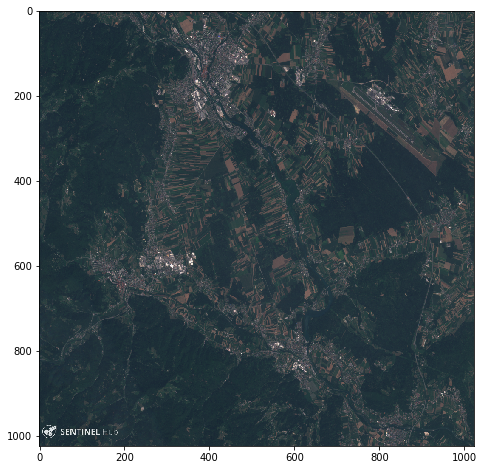

In [9]:
# Kanali v WMS so BGR, Python ima RGB
plt.imshow(wms_true_color_img[-1][..., [2, 1, 0]])

In [10]:
print('Sentinel-2: ', wms_true_color_request.get_dates()[-1])

Sentinel-2:  2017-07-20 10:00:27


## Iskanje posnetkov s parametri

Poiščimo posnetke v izbranem časovnem obdobju.

In [11]:
search_bbox = shub.BBox(bbox=kranj_bbox, crs=shub.CRS.WGS84)
search_time_interval = ('2015-01-01', '2018-12-31')

In [12]:
# Poiščemo posnetke
wfs_iterator = shub.WebFeatureService(search_bbox, search_time_interval,
                                      data_source=shub.DataSource.SENTINEL2_L1C,
                                      maxcc=1.0, instance_id=INSTANCE_ID)

In [13]:
for tile_info in wfs_iterator:
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.685452604, 46.946153376], [15.128253782, 46.95362835], [15.125954377, 45.965490741], [13.709012563, 45.958267833], [13.685452604, 46.946153376]]]]}, 'properties': {'id': 'S2B_OPER_MSI_L1C_TL_MPS__20180630T134105_A006869_T33TVM_N02.06', 'date': '2018-06-30', 'time': '10:06:40', 'path': 's3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/30/0', 'crs': 'EPSG:32633', 'mbr': '399960,5090220 509760,5200020', 'cloudCoverPercentage': 36.77}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.685452604, 46.946153376], [15.128253782, 46.95362835], [15.125954377, 45.965490741], [13.709012563, 45.958267833], [13.685452604, 46.946153376]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_MPS__20180625T160036_A015706_T33TVM_N02.06', 'date': '2018-06-25

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.685452604, 46.946153376], [15.128253782, 46.95362835], [15.125954377, 45.965490741], [13.709012563, 45.958267833], [13.685452604, 46.946153376]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_SGS__20160824T170427_A006125_T33TVM_N02.04', 'date': '2016-08-24', 'time': '10:06:07', 'path': 's3://sentinel-s2-l1c/tiles/33/T/VM/2016/8/24/0', 'crs': 'EPSG:32633', 'mbr': '399960,5090220 509760,5200020', 'cloudCoverPercentage': 9.82}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.685452604, 46.946153376], [15.128253782, 46.95362835], [15.125954377, 45.965490741], [13.709012563, 45.958267833], [13.685452604, 46.946153376]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_SGS__20160814T152517_A005982_T33TVM_N02.04', 'date': '2016-08-14'

In [14]:
# Vzamemo samo properties in naredimo pandas podatkovni okvir
shub_wfs_df = pd.DataFrame(wfs_iterator.tile_list)['properties'].apply(pd.Series)
# Stolpec date je datum
shub_wfs_df['date'] = pd.to_datetime(shub_wfs_df['date'])

In [15]:
shub_wfs_df.head()

,cloudCoverPercentage,crs,date,id,mbr,path,time
0,36.77,EPSG:32633,2018-06-30,S2B_OPER_MSI_L1C_TL_MPS__20180630T134105_A0068...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/30/0,10:06:40
1,89.57,EPSG:32633,2018-06-25,S2A_OPER_MSI_L1C_TL_MPS__20180625T160036_A0157...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/25/0,10:05:23
2,20.63,EPSG:32633,2018-06-20,S2B_OPER_MSI_L1C_TL_SGS__20180620T170850_A0067...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/20/0,10:06:26
3,38.66,EPSG:32633,2018-06-15,S2A_OPER_MSI_L1C_TL_SGS__20180615T120427_A0155...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/15/0,10:05:22
4,31.37,EPSG:32633,2018-06-10,S2B_OPER_MSI_L1C_TL_MPS__20180610T120934_A0065...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/6/10/0,10:05:34


In [16]:
shub_wfs_df.describe()

,cloudCoverPercentage
count,135.000000
mean,51.700148
std,34.717738
min,0.010000
25%,19.935000
50%,56.650000
75%,86.415000
max,100.000000


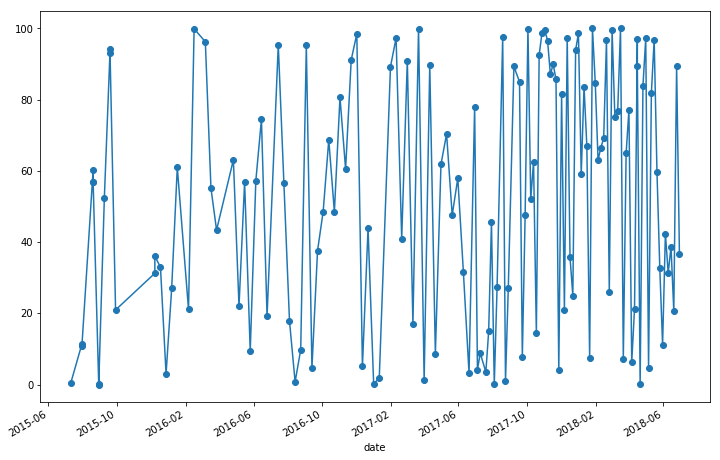

In [31]:
shub_wfs_df.plot(x='date', y='cloudCoverPercentage', style='o-', legend=None)

## Poiščemo posnetke z malo oblakov

In [18]:
shub_wfs_df_cc = shub_wfs_df[shub_wfs_df["cloudCoverPercentage"] < 10]

In [19]:
len(shub_wfs_df_cc)

26

In [20]:
shub_wfs_df_cc

,cloudCoverPercentage,crs,date,id,mbr,path,time
11,4.69,EPSG:32633,2018-05-06,S2A_OPER_MSI_L1C_TL_EPAE_20180506T105839_A0149...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/5/6/0,10:02:14
14,0.03,EPSG:32633,2018-04-21,S2B_OPER_MSI_L1C_TL_SGS__20180421T120642_A0058...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/4/21/0,10:04:27
18,6.22,EPSG:32633,2018-04-06,S2A_OPER_MSI_L1C_TL_EPAE_20180406T110023_A0145...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/4/6/0,10:02:43
21,7.26,EPSG:32633,2018-03-22,S2B_OPER_MSI_L1C_TL_MPS__20180322T120713_A0054...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/3/22/0,10:02:33
33,7.37,EPSG:32633,2018-01-21,S2B_OPER_MSI_L1C_TL_MPS__20180121T121018_A0045...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2018/1/21/0,10:05:42
44,3.95,EPSG:32633,2017-11-27,S2A_OPER_MSI_L1C_TL_MPS__20171127T121327_A0127...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/11/27/0,10:03:39
57,7.69,EPSG:32633,2017-09-23,S2B_OPER_MSI_L1C_TL_MPS__20170925T194222_A0028...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/9/23/0,10:05:02
61,1.01,EPSG:32633,2017-08-24,S2B_OPER_MSI_L1C_TL_SGS__20170824T152919_A0024...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/8/24/0,10:00:22
64,0.10,EPSG:32633,2017-08-04,S2B_OPER_MSI_L1C_TL_EPA__20171025T045822_A0021...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/8/4/0,10:06:08
67,3.53,EPSG:32633,2017-07-20,S2A_OPER_MSI_L1C_TL_SGS__20170720T152910_A0108...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/7/20/0,10:00:27


Izberemo zanimive posnetke, recimo enega v posameznem letu delovanja Sentinela-2:  
2015-07-11  
2016-08-14  
2017-07-20  

In [21]:
# Definiramo datume
kranj_dates_aug = ["2015-07-11", "2016-08-14", "2017-07-20"]
# Izberemo samo vrstice s temi datumi
shub_wfs_df_sel = shub_wfs_df_cc[shub_wfs_df_cc['date'].isin(kranj_dates_aug)]

In [22]:
shub_wfs_df_sel

,cloudCoverPercentage,crs,date,id,mbr,path,time
67,3.53,EPSG:32633,2017-07-20,S2A_OPER_MSI_L1C_TL_SGS__20170720T152910_A0108...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2017/7/20/0,10:00:27
101,0.75,EPSG:32633,2016-08-14,S2A_OPER_MSI_L1C_TL_SGS__20160814T152517_A0059...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2016/8/14/0,10:06:04
134,0.36,EPSG:32633,2015-07-11,S2A_OPER_MSI_L1C_TL_EPA__20160811T174848_A0002...,"399960,5090220 509760,5200020",s3://sentinel-s2-l1c/tiles/33/T/VM/2015/7/11/0,10:00:08


## Določitev podatkovnih nizov

In [23]:
# Prenesemo kanala 4 in 8, ki ju rabimo za izračun NDVI
bands = ['B08', 'B04']
# Metapodatki
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
# Mapa z datotekami
data_folder = './posnetki'

## Prikaz posnetka

In [24]:
kranj_prvi_id = shub_wfs_df_sel["id"].iloc[0]

In [25]:
tile_name, time, aws_index = shub.AwsTile.tile_id_to_tile(kranj_prvi_id)
request = shub.AwsTileRequest(tile=tile_name, time=time, aws_index=aws_index,
                              bands=bands, metafiles=metafiles, data_folder=data_folder)

In [26]:
data_list = request.get_data()

In [27]:
b8a, b10, tile_info, preview, cloud_mask = data_list

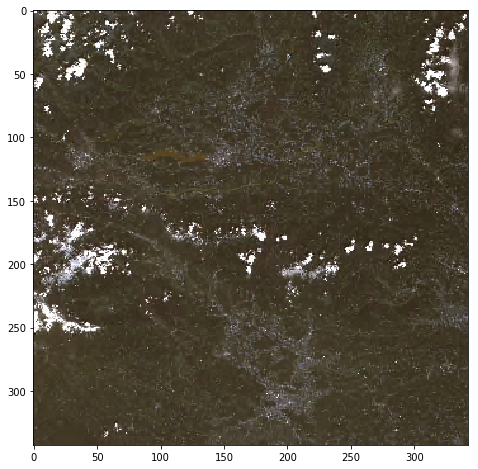

In [28]:
plt.imshow(preview)

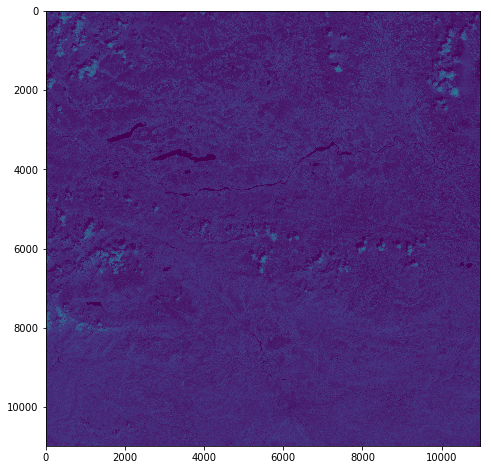

In [29]:
# 8 kanal
# plt.imshow(b8a, cmap='gray')
plt.imshow(b8a)

## Prenos podatkov

Prenesemo vse tri posnetke.

In [30]:
for index, row in shub_wfs_df_sel.iterrows():
    print('Prenašam ', row["date"].strftime('%Y-%m-%d'))
    tile_id = row["id"]
    tile_name, time, aws_index = shub.AwsTile.tile_id_to_tile(tile_id)
    print("Tile ID: ", tile_id)
    print("Tile: ", tile_name)
    request = shub.AwsTileRequest(tile=tile_name, time=time, aws_index=aws_index,
                                  bands=bands, metafiles=metafiles, data_folder=data_folder)
    request.save_data()

Prenašam  2017-07-20
Tile ID:  S2A_OPER_MSI_L1C_TL_SGS__20170720T152910_A010844_T33TVM_N02.05
Tile:  33TVM
Prenašam  2016-08-14
Tile ID:  S2A_OPER_MSI_L1C_TL_SGS__20160814T152517_A005982_T33TVM_N02.04
Tile:  33TVM
Prenašam  2015-07-11
Tile ID:  S2A_OPER_MSI_L1C_TL_EPA__20160811T174848_A000262_T33TVM_N02.04
Tile:  33TVM
